# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Шаги исследования

1. Подготовка данных
2. Анализ данных
3. Модель
4. Общий вывод

## 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor



# Обозначим некоторые переменные, которые пригодятся в работе в дальнейшем
METALS = ['au', 'ag', 'pb']
TARGETS = ['final.output.recovery', 'rougher.output.recovery']
CONCENTRATE = ['rougher.input.feed',
    'rougher.output.concentrate',
    'primary_cleaner.output.concentrate',
    'final.output.concentrate']
RANDOM_STATE = 12345

In [2]:
# Загрузим данные
df_train = pd.read_csv(r'C:\Users\stasf\Desktop\gold_industry_train.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv(r'C:\Users\stasf\Desktop\gold_industry_test.csv', index_col='date', parse_dates=True)
df_full = pd.read_csv(r'C:\Users\stasf\Desktop\gold_industry_full.csv', index_col='date', parse_dates=True)

In [3]:
# Напишем функцию для описания данных
def check_df(df):
    print("Количество строк:", df.shape[0])
    print("Количество столбцов:", df.shape[1])
    df.info()
    display(df.describe())
    display(df.head(5))

In [4]:
check_df(df_train)

Количество строк: 14579
Количество столбцов: 86
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               14579 non-null  float64
 1   rougher.input.feed_ag                               14579 non-null  float64
 2   rougher.input.feed_pb                               14507 non-null  float64
 3   rougher.input.feed_sol                              14502 non-null  float64
 4   rougher.input.feed_rate                             14572 non-null  float64
 5   rougher.input.feed_size                             14478 non-null  float64
 6   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 7   rougher.input.floatbank10_xanthate                  14572 non-null  float6

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [5]:
check_df(df_test)

Количество строк: 4860
Количество столбцов: 52
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a_air             4859 non-null   float64
 9   ro

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,-300.283401,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [6]:
check_df(df_full)

Количество строк: 19439
Количество столбцов: 86
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               19439 non-null  float64
 1   rougher.input.feed_ag                               19439 non-null  float64
 2   rougher.input.feed_pb                               19339 non-null  float64
 3   rougher.input.feed_sol                              19340 non-null  float64
 4   rougher.input.feed_rate                             19428 non-null  float64
 5   rougher.input.feed_size                             19294 non-null  float64
 6   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 7   rougher.input.floatbank10_xanthate                  19431 non-null  float6

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


**Вывод**:
- Выгрузили данные и изучили их;
- Во многих признаках есть пропуски.

In [7]:
# Напишем функцию для рассчета эффективности обогащения
def efficiency_recovery(rougher_output, rougher_input, rougher_tail):
    recovery = (rougher_output * (rougher_input - rougher_tail)) / (rougher_input * (rougher_output - rougher_tail)) * 100
    
    recovery[recovery < 0] = np.nan
    recovery[recovery > 100] = np.nan
    return recovery

In [8]:
# Применим функцию и найдем эффективность обогащения
efficiency = efficiency_recovery(df_train['rougher.output.concentrate_au'], 
    df_train['rougher.input.feed_au'], 
    df_train['rougher.output.tail_au'])

In [9]:
print(efficiency.describe())

count    14579.000000
mean        82.521200
std         15.797521
min         -0.000000
25%         80.558542
50%         85.946497
75%         89.960375
max        100.000000
dtype: float64


In [10]:
# Посчитаем MAE
mae_recovery = mean_absolute_error(df_train['rougher.output.recovery'].dropna(), efficiency.dropna())
print('MAE =', mae_recovery)

MAE = 9.83758577644259e-15


**Вывод**:
Стандартное отклонение оказалось довольно небольшим, а значит эффективность рассчитана правильно.

In [11]:
# Выведем признаки, которые недоступны в тестовой выборке
a = df_test.columns
b = df_train.columns
c = []
for i in b:
    if i not in a:
        c.append(i)
print(df_train[c].dtypes)
print("Количество отсутсвующих признаков в тестовой выборке:", len(c))

rougher.calculation.sulfate_to_au_concentrate         float64
rougher.calculation.floatbank10_sulfate_to_au_feed    float64
rougher.calculation.floatbank11_sulfate_to_au_feed    float64
rougher.calculation.au_pb_ratio                       float64
rougher.output.concentrate_au                         float64
rougher.output.concentrate_ag                         float64
rougher.output.concentrate_pb                         float64
rougher.output.concentrate_sol                        float64
rougher.output.recovery                               float64
rougher.output.tail_au                                float64
rougher.output.tail_ag                                float64
rougher.output.tail_pb                                float64
rougher.output.tail_sol                               float64
primary_cleaner.output.concentrate_au                 float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_

**Вывод**:
- Скорее всего, в тестовом датасете отсутсвуют те признаки, которые являются либо целевыми, либо расчетными;
- Все признаки имеют тип данных `float64`.

In [12]:
print("Количество дупликатов:", df_train.duplicated().sum())

Количество дупликатов: 0


In [13]:
print("Количество дупликатов:", df_test.duplicated().sum())

Количество дупликатов: 0


In [14]:
print("Количество дупликатов:", df_full.duplicated().sum())

Количество дупликатов: 0


In [15]:
# Вытянем соответствующие по индексам таргеты из df_full для df_test
print(df_test.shape)
df_test = df_test.merge(df_full[TARGETS].loc[df_test.index], on='date', how='left')
print(df_test.shape)

(4860, 52)
(4860, 54)


In [16]:
# Удалим строки с пропусками в таргетах
df_train = df_train.dropna(subset=TARGETS)
df_test = df_test.dropna(subset=TARGETS)

In [17]:
# Заполним пропуски в датасетах ближайшими предыдущими значениями 
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')

**Вывод**:
- Загрузили и изучили данные;
- Посчитали метрику `MAE` между расчетами и значениями признака `'rougher.output.recovery'` и сделали вывод;
- Проанализировали признаки, которых нет в тестовой выборке: ими оказались целевые признаки или расчетные признаки;
- Убедились в том, что дубликатов нет;
- Заполнили пропуски предыдущими значениями из строки.

## 2. Анализ данных

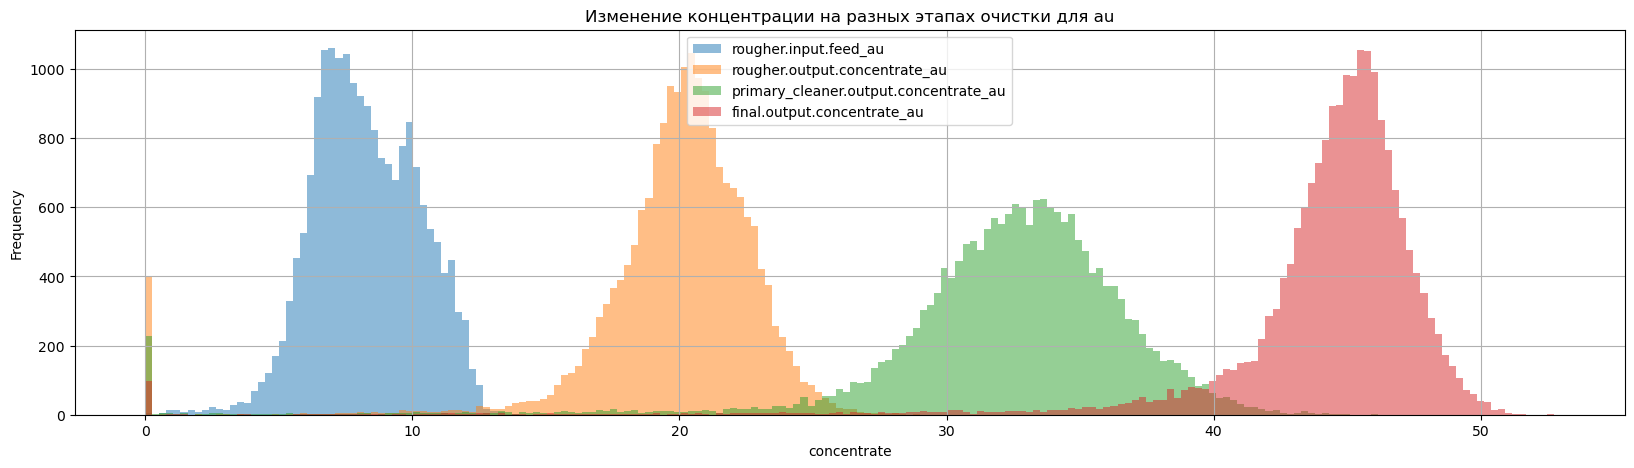

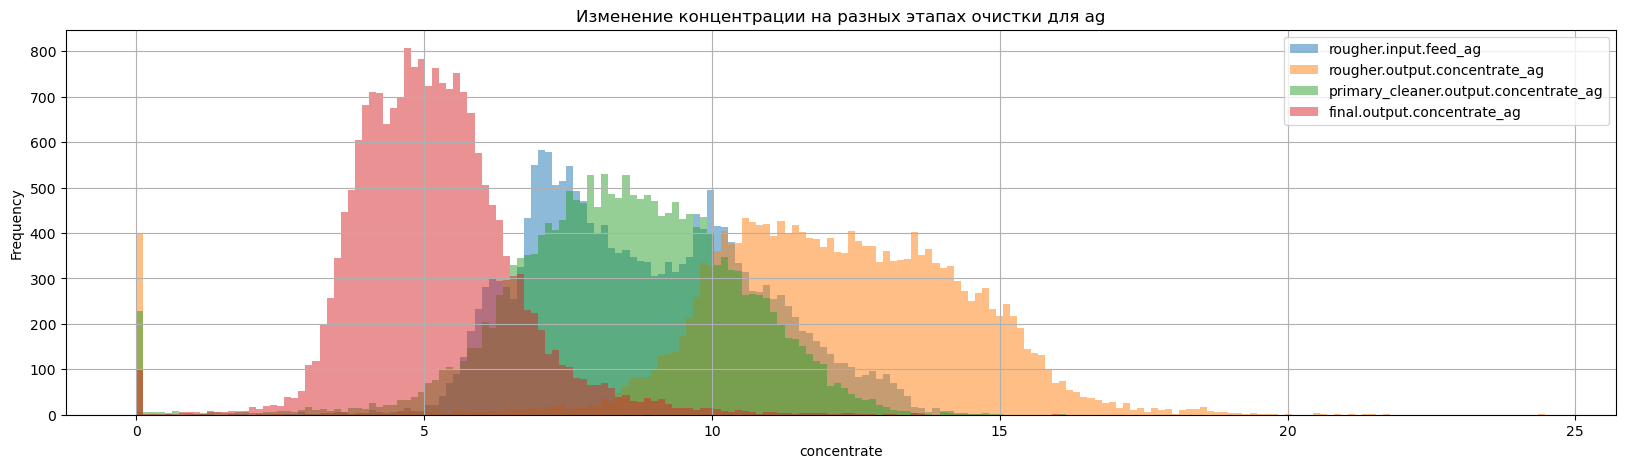

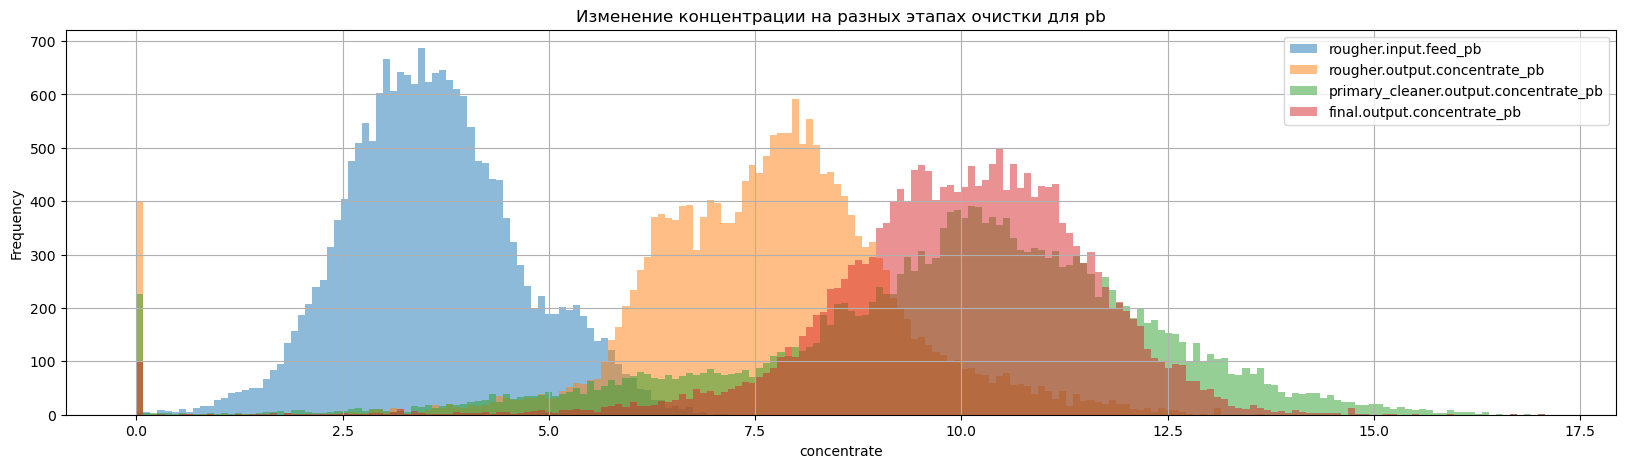

In [18]:
# Изменение концетрации на разных этапах очистки
for metal in METALS:
    met = [f'{x}_{metal}' for x in CONCENTRATE]
    
    df_full[met].plot(
        title = f'Изменение концентрации на разных этапах очистки для {metal}',
        kind='hist', 
        bins=200, 
        grid=True, 
        legend=True,
        figsize=(20, 5),
        alpha=0.5,
    ).set(xlabel='concentrate') 
    
    plt.show()

In [19]:
# Создадим датафрейм со средними значениями концентрации трех металлов (Au, Ag, Pb) на каждом этапе очистки
mean_conc_df = pd.DataFrame({'rougher.input.feed':[df_full['rougher.input.feed_au'].mean(), df_full['rougher.input.feed_ag'].mean(),
                            df_full['rougher.input.feed_pb'].mean()], 'rougher.output.concentrate':[df_full['rougher.output.concentrate_au'].mean(),
                            df_full['rougher.output.concentrate_ag'].mean(), df_full['rougher.output.concentrate_pb'].mean()],
                             'primary_cleaner.output.concentrate':[df_full['primary_cleaner.output.concentrate_au'].mean(), df_full['primary_cleaner.output.concentrate_ag'].mean(), 
                            df_full['primary_cleaner.output.concentrate_pb'].mean()], 'final.output.concentrate':[df_full['final.output.concentrate_au'].mean(),
                            df_full['final.output.concentrate_ag'].mean(), df_full['final.output.concentrate_pb'].mean()]}, index=['au', 'ag', 'pb'])

In [20]:
mean_conc_df

,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
au,8.266097,19.772000,32.119400,44.076513
ag,8.794927,11.994759,8.442408,5.168470
pb,3.598085,7.606272,9.829530,9.978895


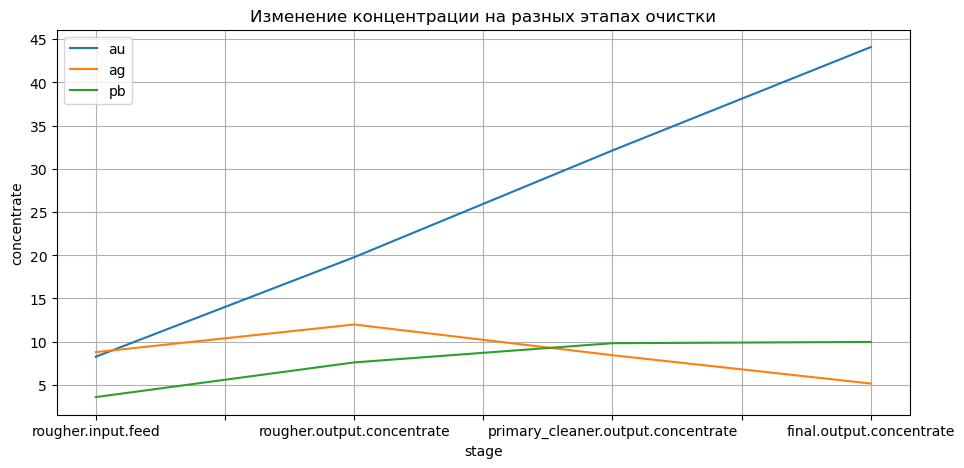

In [21]:
for metal in METALS:
    mean_conc_df.loc[metal].plot(title='Изменение концентрации на разных этапах очистки', 
        grid=True, 
        legend=True, 
        figsize=(11, 5)
    ).set(xlabel='stage', ylabel ='concentrate')
plt.show()

**Вывод об изменении концентрации металлов на разных этапах очистки:**
- Концентрация `Au` линейно растет. В конечном итоге она возросла в **5,33** раза;
- Концентрация `Ag` возрастала до второго этапа, а позже стала падать. В итоге концентрация уменьшилась в **1,7** раз;
- Концентрация `Pb` плавно возрастала и изменилась в **2,77** раз.

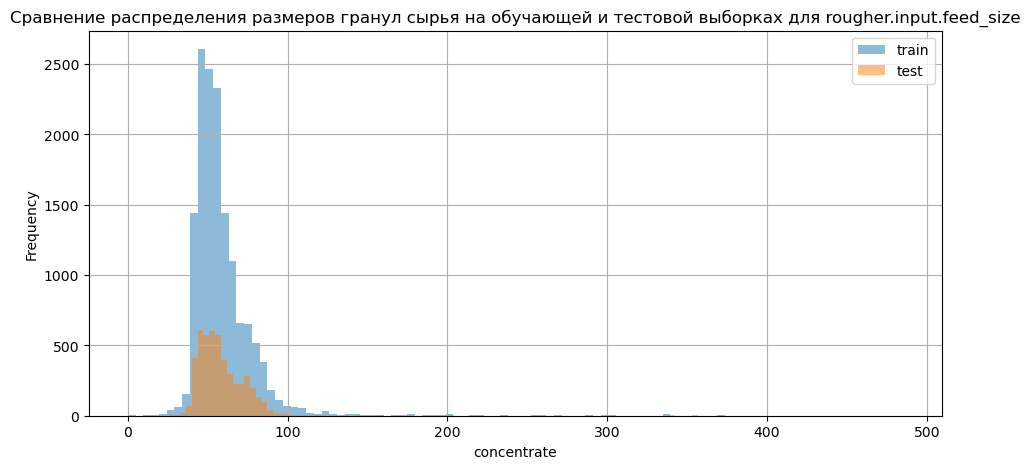

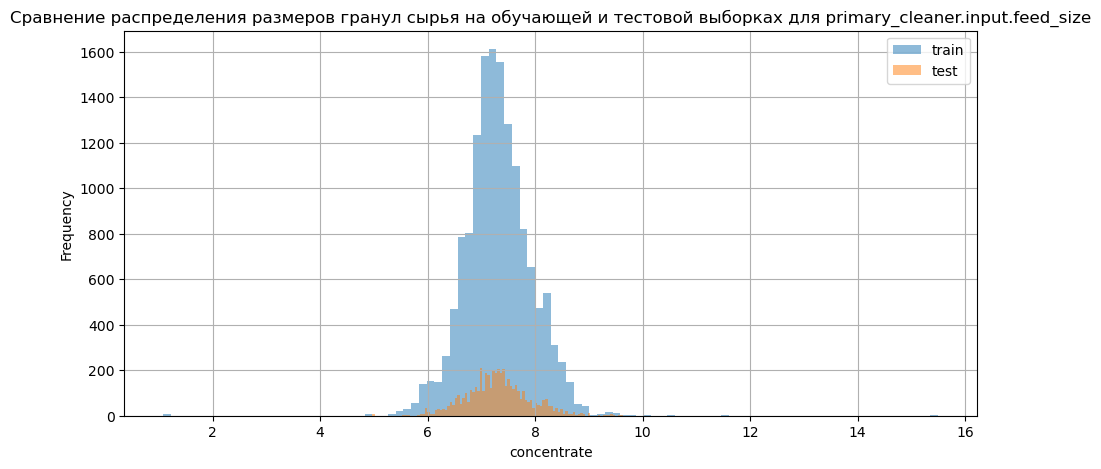

In [22]:
# Сравним распределение размеров гранул сырья на обучающей и тестовой выборках
for metric in ('rougher.input.feed_size', 'primary_cleaner.input.feed_size'):
    for label, df in (('train', df_train), ('test', df_test)): 
        df[metric].plot(
                title = 'Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках для {}'.format(metric),
                kind='hist', 
                bins=100, 
                grid=True, 
                legend=True,
                figsize=(11, 5),
                alpha=0.5,
                label=label,
            ).set(xlabel='concentrate')
  
    plt.show()

**Вывод**: 
Распределения мало отличаются друг от друга, а следовательно оценка будет правильной.

In [23]:
# Суммарная концентрация веществ на разных стадиях. Добавили эту информацию в df_train
for metric in CONCENTRATE:
    df_train[metric] = 0
    for metal in METALS + ['sol']:
        df_train[metric] += df_train['{}_{}'.format(metric, metal)]
    
df_train[CONCENTRATE].head(10)

,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
date,,,,
2016-01-15 00:00:00,51.680034,66.424950,72.640924,63.644396
2016-01-15 01:00:00,50.659114,67.012710,72.543485,63.957723
2016-01-15 02:00:00,50.609929,66.103793,72.095042,64.311180
2016-01-15 03:00:00,51.061546,65.752751,59.957723,63.573449
2016-01-15 04:00:00,47.859163,65.908382,71.321010,64.004667
2016-01-15 05:00:00,48.838521,64.955919,70.607932,63.646320
2016-01-15 06:00:00,49.120760,65.372419,71.165854,63.156407
2016-01-15 07:00:00,50.790724,65.180132,71.533310,62.908843
2016-01-15 08:00:00,50.550288,65.625127,72.072013,64.185763


In [24]:
# Функция для визуализации данных
def concen_desc(column):
    display(column.describe())
    display(column.plot(kind='hist', grid=True, bins=40))
    plt.show()
    display(column.plot(kind='box', grid=True))
    plt.show()

count    14579.000000
mean        57.368141
std          7.337656
min          0.040000
25%         53.571208
50%         57.693000
75%         62.122859
max         76.978947
Name: rougher.input.feed, dtype: float64

<AxesSubplot:ylabel='Frequency'>

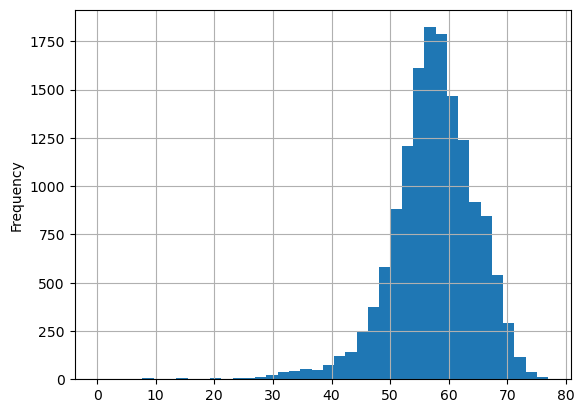

<AxesSubplot:>

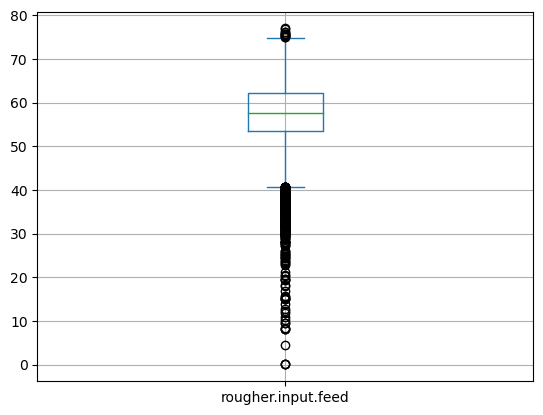

In [25]:
concen_desc(df_train['rougher.input.feed'])

count    14579.000000
mean        67.804972
std         13.739990
min          0.000000
25%         65.991033
50%         70.350734
75%         74.548465
max         88.140119
Name: rougher.output.concentrate, dtype: float64

<AxesSubplot:ylabel='Frequency'>

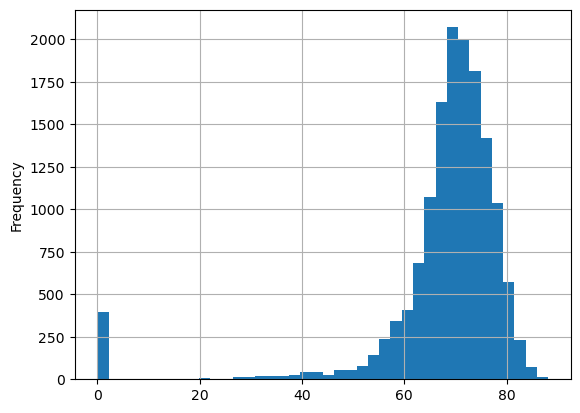

<AxesSubplot:>

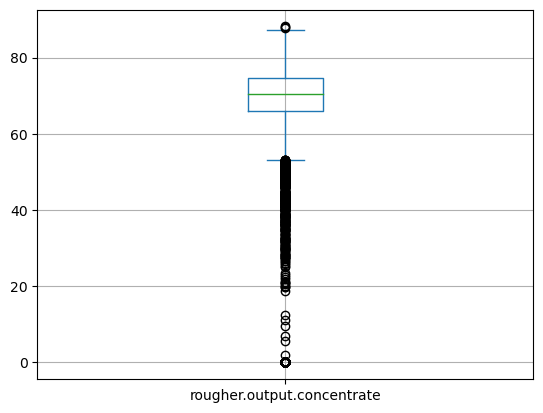

In [26]:
concen_desc(df_train['rougher.output.concentrate'])

count    14579.000000
mean        60.684505
std         10.565578
min          0.000000
25%         58.951881
50%         62.541132
75%         65.825712
max         78.255313
Name: primary_cleaner.output.concentrate, dtype: float64

<AxesSubplot:ylabel='Frequency'>

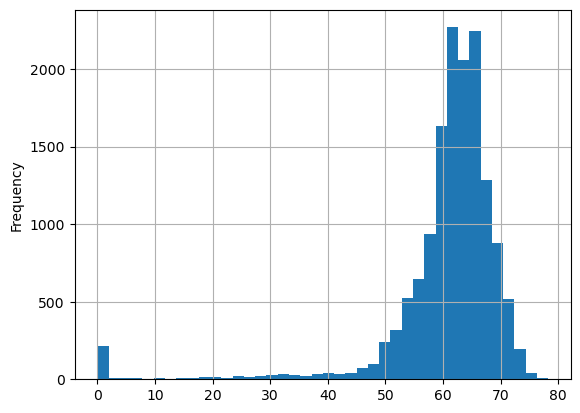

<AxesSubplot:>

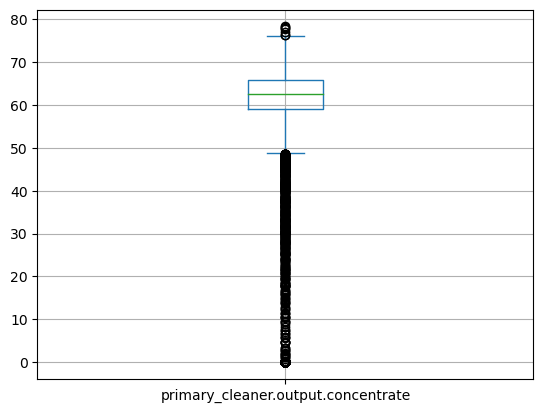

In [27]:
concen_desc(df_train['primary_cleaner.output.concentrate'])

count    14579.000000
mean        68.572035
std          8.012399
min          0.000000
25%         68.014187
50%         69.664788
75%         71.419521
max         80.210644
Name: final.output.concentrate, dtype: float64

<AxesSubplot:ylabel='Frequency'>

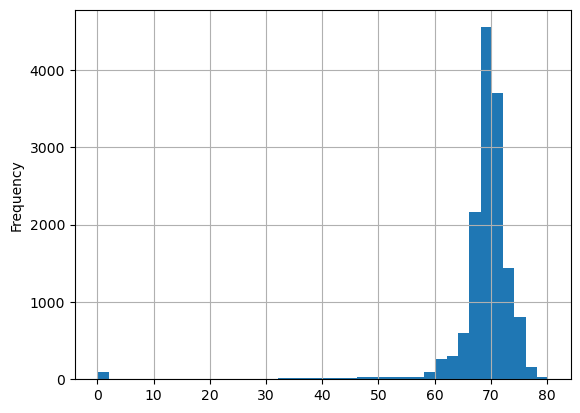

<AxesSubplot:>

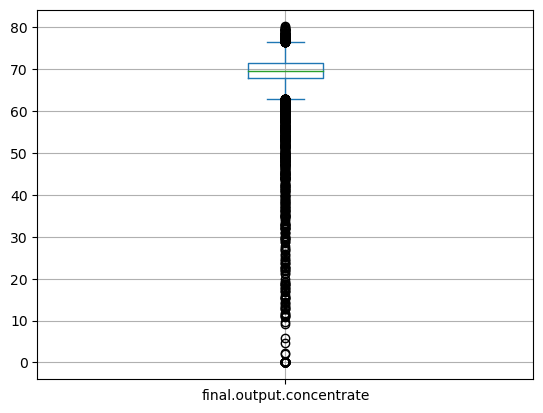

In [28]:
concen_desc(df_train['final.output.concentrate'])

In [29]:
def function_1(df, concentrate):
    for col in concentrate:
        q1 = df[col].quantile(q=0.25)
        q3 = df[col].quantile(q=0.75)
        iqr = q3-q1
        df = df.loc[df[col] > (q1 - 1.5*iqr)]
        df = df.loc[df[col] < (q3 + 1.5*iqr)]
    return df    

In [30]:
function_1(df_train, CONCENTRATE)

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297,51.680034,66.424950,72.640924,63.644396
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514,50.659114,67.012710,72.543485,63.957723
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849,50.609929,66.103793,72.095042,64.311180
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835,51.061546,65.752751,59.957723,63.573449
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-09 09:59:59,4.599524,5.822083,4.255546,37.480479,559.895089,85.247019,6.775864,9.005425,1200.454685,-300.012582,...,7.053796,64.054699,1.761994,8.578502,3.365823,10.603464,52.157631,70.619923,60.501479,68.600349
2017-12-09 10:59:59,4.658125,5.844800,4.241564,37.395565,561.464855,83.860651,6.770561,9.000889,1200.958146,-300.013649,...,6.929418,68.643324,1.567363,8.792890,3.120351,10.184715,52.140053,70.610025,59.432141,68.504562
2017-12-09 11:59:59,5.335862,6.091855,4.617558,37.369774,560.889077,85.718304,7.762770,9.158609,1199.245914,-300.845518,...,6.803482,73.755150,1.529220,8.769645,3.141541,10.403181,53.415050,70.781325,59.001692,68.098589


**Вывод**:
- Исследовали суммарную концентрацию всех металлов на каждом этапе обработки;
- В тренировочной выборке удалили строки, содержащие аномальные значения - **16,2%** от объема всей выборки.

## 3. Модель

In [31]:
# Напишем функцию для расчета итоговой sMAPE
def smape(target, prediction):
    prediction_df = pd.DataFrame(prediction)
    target_1 = np.array(target['rougher.output.recovery'])
    prediction_1 = np.array(prediction_df.loc[:, 1])
    target_2 = np.array(target['final.output.recovery'])
    prediction_2 = np.array(prediction_df.loc[:, 0])
    
    count_1 = np.sum(2 * np.abs(target_1 - prediction_1) / (np.abs(target_1) + np.abs(prediction_1) + 1e-10))
    smape_rougher = (count_1 / len(target_1)) * 100 
   
    count_2 =  np.sum(2 * np.abs(target_2 - prediction_2) / (np.abs(target_2) + np.abs(prediction_2) + 1e-10))
    smape_final = (count_2 / len(target_2)) * 100 
    grand_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return grand_smape

In [32]:
# Функция для нахождения разницы в столбцах между двумя датасетами
def fields_diff(first_df, second_df):
    return set(first_df.columns.to_list()) - set(second_df.columns.to_list())

In [33]:
# Удалим ненужные столбцы
missing_test_fields = fields_diff(df_train, df_test)
print(missing_test_fields)
df_train = df_train.drop(missing_test_fields, axis='columns')
print(fields_diff(df_train, df_test))
print(fields_diff(df_test, df_train))


{'rougher.output.concentrate_ag', 'final.output.concentrate_au', 'primary_cleaner.output.concentrate_sol', 'rougher.output.concentrate_sol', 'final.output.tail_sol', 'primary_cleaner.output.tail_sol', 'rougher.output.concentrate', 'final.output.concentrate_ag', 'secondary_cleaner.output.tail_ag', 'final.output.concentrate_pb', 'rougher.output.tail_sol', 'rougher.input.feed', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.concentrate_au', 'final.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'rougher.output.concentrate_pb', 'secondary_cleaner.output.tail_au', 'final.output.concentrate_sol', 'rougher.output.tail_ag', 'rougher.output.concentrate_au', 'secondary_cleaner.output.tail_sol', 'final.output.tail_pb', 'primary_cleaner.output.tail_au', 'rougher.calculation.au_pb_ratio', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'secondary_cleaner.output.tail_pb', 'primary_clean

In [34]:
# Создаем scorer
scorer = make_scorer(smape, greater_is_better=False)

In [35]:
# Разделим датасеты на признаки и таргеты
features_train = df_train.drop(TARGETS, axis=1)
target_train = df_train[TARGETS]
features_test = df_test.drop(TARGETS, axis=1)
target_test = df_test[TARGETS]

In [36]:
target_train

,final.output.recovery,rougher.output.recovery
date,,
2016-01-15 00:00:00,70.541216,87.107763
2016-01-15 01:00:00,69.266198,86.843261
2016-01-15 02:00:00,68.116445,86.842308
2016-01-15 03:00:00,68.347543,87.226430
2016-01-15 04:00:00,66.927016,86.688794
...,...,...
2017-12-09 09:59:59,64.054699,87.684717
2017-12-09 10:59:59,68.643324,90.677361
2017-12-09 11:59:59,73.755150,89.574376


In [37]:
# Решающее дерево
param_grid = {'max_depth': range(2, 15)}

model_1 = DecisionTreeRegressor(random_state=RANDOM_STATE)
search_1 = GridSearchCV(model_1, param_grid, cv=5, scoring=scorer)
search_1.fit(features_train, target_train)
print('Лучшее значение sMAPE для дерева решений: {} при значениях гиперпараметров: {}'.format(round(-search_1.best_score_, 2), search_1.best_params_))

Лучшее значение sMAPE для дерева решений: 11.66 при значениях гиперпараметров: {'max_depth': 3}


In [ ]:
# Случайный лес
param_grid = {'n_estimators': range(10, 40, 5)}

model_2 = RandomForestRegressor(max_depth=2, random_state=RANDOM_STATE)
search_2 = GridSearchCV(model_2, param_grid, cv=5, scoring=scorer)
search_2.fit(features_train, target_train)
print('Лучшее значение sMAPE для случайного леса: {} при значениях гиперпараметров: {}'.format(round(-search_2.best_score_, 2), search_2.best_params_))

In [ ]:
# Линейная регрессия 
model_3 = LinearRegression()
search_3 = cross_val_score(model_3, features_train, target_train, cv=5, scoring=scorer)
print('Значение sMAPE для линейной регрессии: {}'.format(round(pd.Series(-search_3).mean(), 2)))

In [ ]:
# Проверка моделей на адекватность
model_4 = DummyRegressor(strategy="mean")
model_4.fit(features_train, target_train)
predictions_4 = model_4.predict(features_test)
print('Итоговое sMAPE для DummyRegressor:', round(smape(
    target_test, predictions_4).mean(), 2))

In [ ]:
# Проверка лучшей модели на тестовой выборке
predictions = search_2.predict(features_test)
x = smape(target_test, predictions)
print(round(x, 2))

## 4. Общий вывод

**Вывод:**
- Загрузили и изучили данные;
- Посчитали метрику `MAE` между расчетами и значениями признака `'rougher.output.recovery'` и сделали вывод;
- Проанализировали признаки, которых нет в тестовой выборке: ими оказались целевые признаки или расчетные признаки;
- Убедились в том, что дубликатов нет;
- Заполнили пропуски предыдущими значениями из строки.
- Обучили три модели: `Решающее дерево`, `Случайный лес`, `Линейная регрессия`.
- Лучшее качество на тренировочных данных показала модель `Случайный лес` - `11.41`. На тестовых данных метрика `sMAPE` оказалась равна `7.98`.